In [3]:
# virtualenv check
import sys

def get_base_prefix_compat():
    """Get base/real prefix, or sys.prefix if there is none."""
    return getattr(sys, "base_prefix", None) or getattr(sys, "real_prefix", None) or sys.prefix

def in_virtualenv():
    return get_base_prefix_compat() != sys.prefix

print(in_virtualenv())

True


# Greetings!

## Simple Keyword Recognition on a google coral TPU

This notebook serves as a simple showcase and tutorial on how to train a rudimentary speech-recognition neural network. Because there are already good guides on this topic, we'll add a little "edge" to it (heh) by venturing into the territory of microcontrollers and tpu. Here, size matters, for which tensorflow handily offers the tensorflow lite library. With functions to convert normal keras models to their lite versions, we'll see how this affects size and performance.

To keep training times low and model size small, we'll focus on keywords (often times also called wakewords like "Hey Siri"), meaning short utterances like "on" and "off".

Our final goal will be to deploy our model on a google coral tensor processing unit (tpu). As mentioned, for this project we'll use the tensorflow framework. This will also make the model creation, paramter searching and training a breeze. On top of that, tensorflow has strong deployment options.

This notebook concerns only the dataset, neural network, training and testing pipelines and the conversion to lite. Another notebook will cover model deployment in an end-to-end system on a raspberry pi with connected tpu.

### Content
- Tensorflow Datasets
- Preprocessing
    - Feature Extraction
    - Input Pipeline
- Neural Network
- Training
- Testing
- Tf-Lite Conversion and Quantization

In [2]:
# Imports

import tensorflow as tf
import tensorflow_datasets as tfds


## Tensorflow Datasets

Tensorflow datasets (tfds) are a quick way of acquiring data. The dataset object comes with a multitude of methods to transform the data and serve it to the model. It also conviently displays info about the dataset.

In [4]:
dataset_name = "speech_commands"


speech_builder = tfds.builder(dataset_name)

In [5]:
"""!!! DOWNLOAD WARNING !!!

This cells downloads the speech commands dataset. Will not download twice, if it detects an already
downloaded version.

"""

# looking for speech commands dataset in all available datasets...
for ele in tfds.list_builders():
    if "speech" in ele:
        print(ele)

dataset_name = "speech_commands"

# instantiate a dataset builder (see tensorflow dataset builder)
speech_builder = tfds.builder(dataset_name)
print(speech_builder.info)

# download data into existing data folder
speech_builder.download_and_prepare()


gtzan_music_speech
librispeech
librispeech_lm
ljspeech
speech_commands
tfds.core.DatasetInfo(
    name='speech_commands',
    version=0.0.2,
    description='An audio dataset of spoken words designed to help train and evaluate keyword
spotting systems. Its primary goal is to provide a way to build and test small
models that detect when a single word is spoken, from a set of ten target words,
with as few false positives as possible from background noise or unrelated
speech. Note that in the train and validation set, the label "unknown" is much
more prevalent than the labels of the target words or background noise.
One difference from the release version is the handling of silent segments.
While in the test set the silence segments are regular 1 second files, in the
training they are provided as long segments under "background_noise" folder.
Here we split these background noise into 1 second clips, and also keep one of
the files for the validation set.',
    homepage='https://arxiv.org/a

In [6]:
"""Get some info from the builder about the dataset"""
builder_info = speech_builder.info
num_labels = builder_info.features['label'].num_classes
label_list = builder_info.features['label'].names

"""Not we actually acquire the dataset object. As supervised gives us a dataset of tuples: data and label"""
data = speech_builder.as_dataset(as_supervised=True)

assert isinstance(data, dict)

print("Labels are:\n{}\n".format(label_list))

test_set = data['test']
train_set = data['train']
validation_set = data['validation']

# I've got these numbers by simple iterating through the datasets, but I'm sure there's a more elegant way
test_set_size = 4890
train_set_size = 85511
validation_set_size = 10102

print("Lets look directly at the first element of the dataset.\nBecause it is a {},\
we need to iterate through it in order to actually load elements.\n".format(type(test_set)))
for thing in test_set:
    print("The dataset consists of: ", type(thing))
    
    print("How does a label object look like: ", thing[1])
    print("How does a audio object look like: ", thing[0])
    break

Labels are:
['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']

Lets look directly at the first element of the dataset.
Because it is a <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>,we need to iterate through it in order to actually load elements.

The dataset consists of:  <class 'tuple'>
How does a label object look like:  tf.Tensor(7, shape=(), dtype=int64)
How does a audio object look like:  tf.Tensor([  -1   -2   -2 ... -136 -170 -203], shape=(16000,), dtype=int64)


In [7]:
def count_ents(dataset):
    """Counts entities of a given dataset, returns them as dict(labels, count)"""
    result = {}
    for thing in dataset:
        label = thing[1].numpy()
        #print(label)
        #break
        if(label in result):
            result[label] += 1
        else:
            result[label] = 1
    return result

def make_plot(entity_count_dict, label_list):
    """Converts a dict of entity counts to a list, then plots them with the corresponded labels"""
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    # make a distribution
    dist = [entity_count_dict[x] for x in range(len(label_list))]
    ax.bar(label_list, dist)
    plt.show

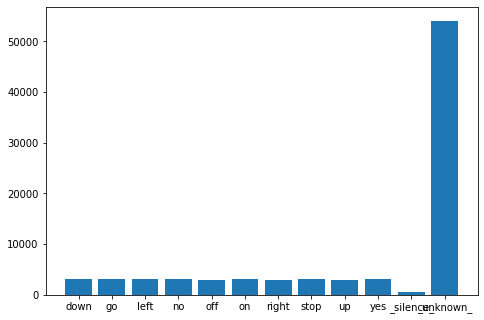

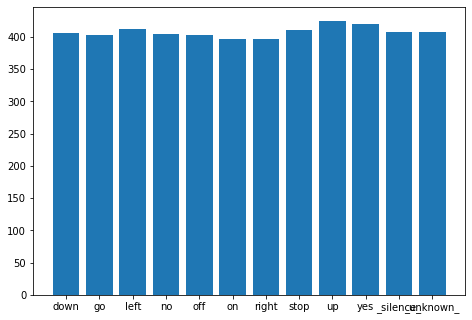

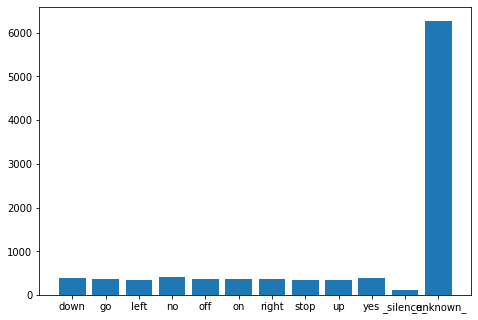

In [8]:
#!pip install matplotlib
import matplotlib.pyplot as plt

"""Get the distributions of commands as a dictionary"""
train_dist = count_ents(train_set)
test_dist = count_ents(test_set)
validation_dist = count_ents(validation_set)

langs = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']

"""Plot the data"""
make_plot(train_dist, langs)
make_plot(test_dist, langs)
make_plot(validation_dist, langs)


We see that for the validaiton and training sets, "unknown" labeled files are present in a much higher number than the desired keywords. This of course makes sense for a keyword recognition system, where most oft the times speech unrelated to our commands is spoken. A system needs to confidently recognize unrelated speech. 

In order to make difference in the actual commands more visible, we now exclude the "unknown" label from our plot and arrive at a better representation of our data. We see that all words have a rather same frequency:

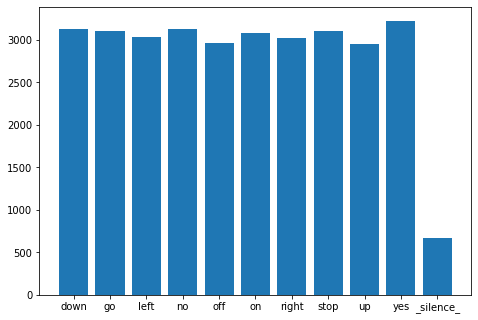

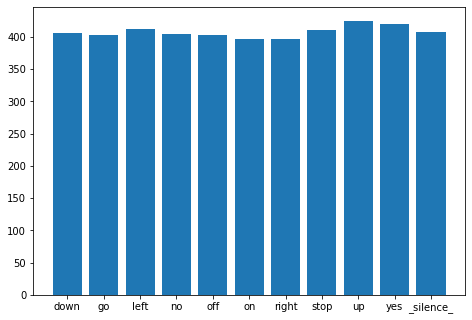

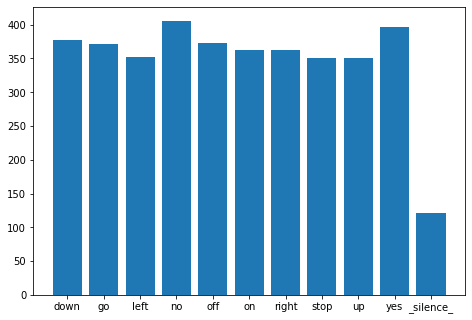

In [9]:
langs = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_']

make_plot(train_dist, langs)
make_plot(test_dist, langs)
make_plot(validation_dist, langs)

## Preprocessing

Before fitting any model, we need to look at our data and preprocess it, in order to make it actually usuable.

### Feature Extraction
#### Data
While raw visual data (eg. rgb pictures) already have enough information for a model to learn from, working with audio requires an additional step: feature extraction. There are attempts to use raw audio data in deep neural networks, but current state of the art systems for speech recognition often use specialized features that are computed from the raw audio signal: mel frequency cepstral coefficents. 

There are audio libaries like librosa that make the extraction rather easy, but because we're working with tensorflow Datasets it's best to stay in its context (otherwise we would've to jump a couple of hurdles because of the way tfds and especially PrefetchDatasets work and trust me, we dont want to do that here...). We find an example how to extract mfcc working with tensorflow tools in the official documentation. Simply pack it into a function (fingers crossed it's working correctly) for later use.


#### Labels
Converting to one hot encodings is only needed when we dont want to use sparse categorical entropy loss,
We further need to convert the labels which are currently simply integers to a one-hot representation. Again, tensorflow already offers a neat function for this.

In [10]:
def make_mfccs(audio, labels):
    
    FRAME_RATE = 16000
    
    stfts = tf.signal.stft(tf.cast(audio, tf.float32), frame_length=1024, frame_step=256,
                       fft_length=1024)
    
    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, num_spectrogram_bins,
                                                                        FRAME_RATE, lower_edge_hertz,
                                                                        upper_edge_hertz)
    
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    # You can use other parts, or even all of the MFCCs, to test around how it affect the accuracy
    mfcc = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]
    
    # Finally add depth to the mfcc tensors, our Conv2D-Model requires this.
    mfcc = tf.expand_dims(mfcc, -1)
    
    return mfcc, labels



### Input Pipeline

While we now have a method to extract mfccs, we need to incorporate it into our input- or data-pipeline. This describes the process of how we feed our data into the model. We want to only work on batches on data (size of a batch can influence model learning) and of course extract our features. We also want to shuffle the data, improving generalization of out model.

We can do all this by directly calling methods of our dataset. While it takes a little time getting used to and finding the correct parameters, the result is clean and straight forward.

In [11]:
dataset_train = train_set.map(make_mfccs
                             ).shuffle(train_set_size
                             ).padded_batch(128
                             ).prefetch(tf.data.experimental.AUTOTUNE)

dataset_test = test_set.map(make_mfccs
                           ).padded_batch(128
                           ).prefetch(tf.data.experimental.AUTOTUNE)

dataset_validation = validation_set.map(make_mfccs
                                       ).padded_batch(128
                                       ).prefetch(tf.data.experimental.AUTOTUNE)






## Neural Network

Because we're limited through our use of tensorflow lite, but also because we want to keep it simple, we use a rather simple composition of layers for our neural network. 

Following the standards, we use 2D-convolutional layers to highlight important features. As regulations batchnormalization layers are used and rectified liniear units as activation functions. Finally a pooling layer builds the end of one layer-block.

In [8]:

import keras
from keras import Sequential
from keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Softmax
from kapre.composed import get_melspectrogram_layer, get_log_frequency_spectrogram_layer

input_shape = (59,13,1)

model = keras.Sequential()



model.add(Conv2D(128, (3), strides=1, input_shape=input_shape))
model.add(Conv2D(128, (3), strides=1))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=2, padding="valid"))

model.add(Conv2D(64, 2, strides=1))
model.add(Conv2D(64, 2, strides=1))
model.add(BatchNormalization())
model.add(ReLU())
#model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

#model.add(Conv2D(6, (2, 2), strides=(2, 2)))
#model.add(Conv2D(16, (2, 2), strides=(2, 2)))
#model.add(BatchNormalization())
#model.add(ReLU())
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels))
#model.add(Dense(1))
model.add(Softmax())

# Compile the model
model.compile('adam', 'sparse_categorical_crossentropy')#, run_eagerly=False)#'categorical_crossentropy', 'mse'
model.build()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 11, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 9, 128)        147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 9, 128)        512       
_________________________________________________________________
re_lu (ReLU)                 (None, 55, 9, 128)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 4, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 3, 64)         32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 2, 64)         1

## Training

Finally we arrive at the training. Because we already did our batching in the dataset-object, we don't really have much else to do here. Of course we still follow standard procedure by using callbacks to stop the training if nothing improved during a period of 10 epochs and saving the model with the best weights.

We could, however, further improve training by using a learn rate adaption technique to handle local minimas, adjust the learning rate during training (giving it velocity) and ... RESEARCH HERE

It is also a good idea to use something like gridsearch to automate parameter testing, which is however heavily memory expensive.

For now, we're content with a simple training loop.

Becaus we currently use the simplest way of utilizing tensorflow datasets with a keras model, validation while training is not possible. We would need to build a iterator generator for the dataset. Maybe I'll implement it later...

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# better to use iterator generators
#model.fit(dataset_1, validation_data=dataset_validation, validation_batch_size=128, epochs=40)
model_nr = str(4)
model_path = "model_"+model_nr+".hdf5"

callbacks = [EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto", restore_best_weights=True),
            ModelCheckpoint(model_path, monitor="loss", verbose=1, save_best_only=True,
                            save_weights_only=False, mode="min",save_freq="epoch",options=None)
            ]
model.fit(dataset_train, epochs=200, callbacks=callbacks)

# eine epoche besteht hier nur aus einem batch! wirklich?

Epoch 1/200
668/669 [============================>.] - ETA: 0s - loss: 1.0389
Epoch 00001: loss improved from inf to 1.03885, saving model to model_4.hdf5
669/669 [==============================] - 263s 394ms/step - loss: 1.0388
Epoch 2/200
668/669 [============================>.] - ETA: 0s - loss: 0.5186
Epoch 00002: loss improved from 1.03885 to 0.51862, saving model to model_4.hdf5
669/669 [==============================] - 246s 367ms/step - loss: 0.5186
Epoch 3/200
668/669 [============================>.] - ETA: 0s - loss: 0.3886
Epoch 00003: loss improved from 0.51862 to 0.38867, saving model to model_4.hdf5
669/669 [==============================] - 201s 301ms/step - loss: 0.3887
Epoch 4/200
668/669 [============================>.] - ETA: 0s - loss: 0.3317
Epoch 00004: loss improved from 0.38867 to 0.33176, saving model to model_4.hdf5
669/669 [==============================] - 193s 288ms/step - loss: 0.3318
Epoch 5/200
668/669 [============================>.] - ETA: 0s - loss: 0

KeyboardInterrupt: 

## Testing

Time of truth, ladies and gents, we're now using our model to predict the words of previously unseen audio!

Simple as it is, we feed our test and validation set into the model and compare its output to the actual labels, voila! Not much else to say here.

Maybe a couple words on the deployment. Following lines of code would be the bedrock of a keyword recognition software. Of course we still have to preprocess the data, but the rest of the main logic relies on these few lines of code. What to do if a specific keyword is recognized, well thats a question for another time (or use case).

In [62]:
import numpy as np

def calc_acc(predictions, dataset):
    total, correct = 0, 0
    index = 0

    for batch in dataset:
        for b_ele in batch[1]:
            #print(b_ele)
            total += 1
            if b_ele == np.argmax(predictions[index]):
                correct += 1
            index += 1


    print("{} out of {} correct, resulting in an accuracy of {}\n".format(correct, total, (correct/total)*100))  

In [70]:
preds_val = model.predict(dataset_validation, verbose=1)
preds_test = model.predict(dataset_test, verbose=1)


39/39 [==============================] - 21s 530ms/step


#### Tip of the day:

It's always a good idea to make three checks when working with data in general:
- What data type are you getting?
- What data shape are you getting?
- What data are you actually getting?

Always checking these three, even if you think you know what you've got, can save you alot of trouble and reassure your way of thinking.

In [40]:
print(type(preds_val))
print(preds_val.shape)
print(preds_val[0])

<class 'numpy.ndarray'>
(10102, 12)
[3.5163629e-04 2.6183114e-03 1.8488441e-01 8.0643678e-01 1.5516784e-05
 1.1606327e-05 2.6408462e-03 6.4246313e-05 1.4864680e-03 9.9873240e-04
 1.1137000e-06 4.9026223e-04]


In [71]:
calc_acc(preds_val, dataset_validation)
calc_acc(preds_test, dataset_test)

9415 out of 10102 correct, resulting in an accuracy of 93.19936646208672

4146 out of 4890 correct, resulting in an accuracy of 84.78527607361963



In [143]:
import random
total = 0
correct = 0

for target in y_test_trans:
    total += 1
    pred_idx = random.randrange(0, 11)
    #print(pred_idx)
    if target[pred_idx]==1:
        correct += 1

print("{} out of {} correct, resulting in an accuracy of {}".format(correct, total, (correct/total)*100))

406 out of 4890 correct, resulting in an accuracy of 8.302658486707566


In [ ]:
""" Further train the model with validaton set """

## Tf-Lite Conversion and Quantization

We're now in the postition to convert our model to tflite format, which greatly reduces its size. We also want to quantize it, bringing the weights from float32 to int16. This comes with a reduction in accuracy, but needs to be done if we want to run the model on an tpu, like google corals tpu-accelerator.

#### A Note:
We're using post-training quantization, which reduces the precision of a models weights from float to int. While this is quick, the model potentially loses a good amout of accuracy. This can be combated by using a quantization aware training approach. Here, fake quantization nodes are introduced which help the model to compensate for the information loss of quantization. 

Quantization aware training usually increases the training time, which is why we refrained from it. It would be  easy to implement nonetheless, using following lines before the training process.

import tensorflow_model_optimization as tfmot
qat_model = tfmot.quantization.keras.quantize_model(your_keras_model)



In [56]:
"""Tensorflow lite converter"""

#
#
#ToDo: 
# Full interger quantization
#https://www.tensorflow.org/lite/performance/post_training_integer_quant?hl=en#convert_using_integer-only_quantization
#https://www.tensorflow.org/lite/performance/post_training_quantization?hl=en
#
# useful link: https://towardsdatascience.com/a-tale-of-model-quantization-in-tf-lite-aebe09f255ca

import tensorflow.lite as lite
from tensorflow import keras
model = keras.models.load_model('model_4.hdf5')

converter = lite.TFLiteConverter.from_keras_model(model)
# This
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()



INFO:tensorflow:Assets written to: /var/folders/mx/q84y7s0d107182d1vknn_rmh0000gn/T/tmpj3oj6969/assets


INFO:tensorflow:Assets written to: /var/folders/mx/q84y7s0d107182d1vknn_rmh0000gn/T/tmpj3oj6969/assets


In [25]:
"""
But wait! We only converted weights to int, but not the input and output nodes! 
We need some additional limes for this...
We need a representative dataset because it "(..) can be used to evaluate optimizations by the converter. 
E.g. converter can use these examples to estimate (min, max) ranges by calibrating the model on inputs." Yep.
"""
import tensorflow.lite as lite
from tensorflow import keras
model = keras.models.load_model('model_4.hdf5')

def representative_data_gen():
    for input_value in dataset_test.take(100):
        # Remember, we get a tuple of (audio, label) tensors, also we added an additional dimension to it, so...
        #in_val = tf.squeeze(input_value[0], axis=0)
        #print(type(in_val), in_val.shape)
        yield [input_value[0]]
        #yield [in_val]
        
converter = lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# 
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/mx/q84y7s0d107182d1vknn_rmh0000gn/T/tmpn77kplom/assets


INFO:tensorflow:Assets written to: /var/folders/mx/q84y7s0d107182d1vknn_rmh0000gn/T/tmpn77kplom/assets


In [26]:
# Save the model. TODO: print size of normal and lite model
with open('model_full_ints.tflite', 'wb') as f:
    f.write(tflite_model_quant)